In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *

import datetime


In [2]:

INFLUX_DB_IP = '10.12.97.178'
INFLUX_DB_PORT = 8086
INFLUX_DB = 'demoDb'
TARGET_MEASUREMENT = 'EM_main_new'

con_obj = InfluxDBClient(host=INFLUX_DB_IP, port=INFLUX_DB_PORT, database=INFLUX_DB)
query = 'select "time", "DeviceID","EM_TOTAL_Import_Energy(kWh)" from ' + TARGET_MEASUREMENT + ' where time > now() - 14d '
df1 = pd.DataFrame(con_obj.query(query, chunked=True, chunk_size=10000).get_points())
df1['time'] = df1['time'].astype('datetime64[ns]')

In [3]:
df1.head()

,time,DeviceID,EM_TOTAL_Import_Energy(kWh)
0,2020-06-18 03:54:19.378956032,EM5,262936.0
1,2020-06-18 03:54:19.475649024,EM6,269097.1
2,2020-06-18 03:54:19.912177152,EM4,210862.0
3,2020-06-18 03:54:20.652488960,EM9,33202.4
4,2020-06-18 03:54:20.806804992,EM7,36.2


In [4]:
date_old = pd.datetime.now().date() - pd.offsets.Day(10)
date_now = pd.datetime.now().date() - pd.offsets.Day(2)
df1 = df1[(df1['time'] >= date_old) & (df1['time'] < date_now)]



In [5]:
df1['time'].min()

Timestamp('2020-06-19 00:00:00.135276032')

In [6]:
df1['time'].max()

Timestamp('2020-06-26 23:59:59.793968896')

In [7]:
INFLUX_DB_IP = '10.12.97.178'
INFLUX_DB_PORT = 8086
INFLUX_DB = 'demoDb'
TARGET_MEASUREMENT = 'EM_live'

con_obj = InfluxDBClient(host=INFLUX_DB_IP, port=INFLUX_DB_PORT, database=INFLUX_DB)
query = 'select  "time", "DeviceID","EM_TOTAL_Import_Energy(kWh)"  from ' + TARGET_MEASUREMENT + ' where time > now() - 2d '
df2 = pd.DataFrame(con_obj.query(query, chunked=True, chunk_size=10000).get_points())
df2['time'] = df2['time'].astype('datetime64[ns]')


In [8]:
date_old = pd.datetime.now().date() - pd.offsets.Day(1)
date_now = pd.datetime.now().date() - pd.offsets.Day(0)
df2 = df2[(df2['time'] >= date_old) & (df2['time'] < date_now)]



In [9]:
df3 = pd.concat([df1, df2], ignore_index = True).drop_duplicates('time')


In [56]:
df3.time.min()

Timestamp('2020-06-19 00:00:00.135276032')

In [57]:
df3.time.max()

Timestamp('2020-06-28 23:59:59.631051008')

In [10]:
#df1 = df[ (df['time'] >= '2020-06-18 00:00:00.000000000') & (df['time'] < '2020-06-19 00:00:00.000000000') ]
#df1 = df3[['time', 'EM_TOTAL_Import_Energy(kWh)','DeviceID']]


In [11]:
# class half_an_hour_min_energy:
    
#     def difference(self, df1):
#         try:
#             x = df1.groupby(pd.Grouper(freq='30T',key='time'))['EM_TOTAL_Import_Energy(kWh)'].apply(lambda x:x.iloc[-1]-x.iloc[0])
#             return x
#         except:
            


#     def output(self, df1):
#         y = pd.DataFrame(df1.groupby('DeviceID').apply(self.difference)).reset_index()
#         y = y.pivot(index = 'time', columns = 'DeviceID', values = 'EM_TOTAL_Import_Energy(kWh)')
#         y = y.rename_axis(None, axis = 1)
#         y = y.fillna(0)
#         return y

# cat = half_an_hour_min_energy()
# df = cat.output(df1)
# df.index.freq = '30T'
# df.head(2)

In [12]:
# class half_an_hour_min_energy:  
    
#     def difference(self,df3):
#         diff = []
#         for g,i in df3.groupby(pd.Grouper(freq='30T',key='time'))['EM_TOTAL_Import_Energy(kWh)']:
#             try:
#                 diff.append([g,i.iloc[-1]-i.iloc[0]])
#             except:
#                 diff.append([g,np.nan])
#         x=pd.DataFrame(diff)
#         x.index=x[0]
#         x=pd.Series(x[1])
#         return x        
                
#     def output(self, df3):
#             y = df3.groupby('DeviceID').apply(self.difference).reset_index().T
#             new_header = y.iloc[0]
#             y = y[1:] #take the data less the header row
#             y.columns = new_header 
#             y = y.reset_index()
#             y.columns.name = None
#             y = y.rename(columns={0: ""})
#             y = y.set_index("")
#             y = y.fillna(0)
#             return y   

In [13]:
########## Final

class half_an_hour_min_energy:  
    
    def difference(self,df3):
        diff = []
        for g,i in df3.groupby(pd.Grouper(freq='30T',key='time'))['EM_TOTAL_Import_Energy(kWh)']:
            try:
                diff.append([g,i.iloc[-1]-i.iloc[0]])
            except:
                diff.append([g,np.nan])
        x=pd.DataFrame(diff)
        return x        
                
    def output(self, df3):
            y = df3.groupby('DeviceID').apply(self.difference)
            y = y.pivot_table(index=0,columns='DeviceID',values=1).reset_index()
            y.columns.name = None
            y = y.rename(columns={0: ""})
            y = y.set_index("")
            y = y.fillna(0)
            return y

In [15]:
cat = half_an_hour_min_energy()
df = cat.output(df3)
#df.index.freq = '30T'
df.head(2)

,EM1,EM10,EM2,EM22,EM23,EM4,EM5,EM6,EM7,EM9
,,,,,,,,,,
2020-06-19 00:00:00,413.0,19.2,0.0,1.7,12.4,148.0,121.0,0.0,0.0,19.6
2020-06-19 00:30:00,474.0,19.4,0.0,1.7,12.3,152.0,135.0,0.0,0.1,21.8


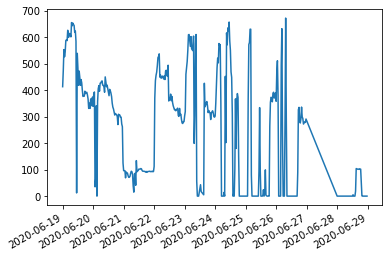

In [16]:
df['EM1'].plot()

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import sklearn.linear_model as skl_lm
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

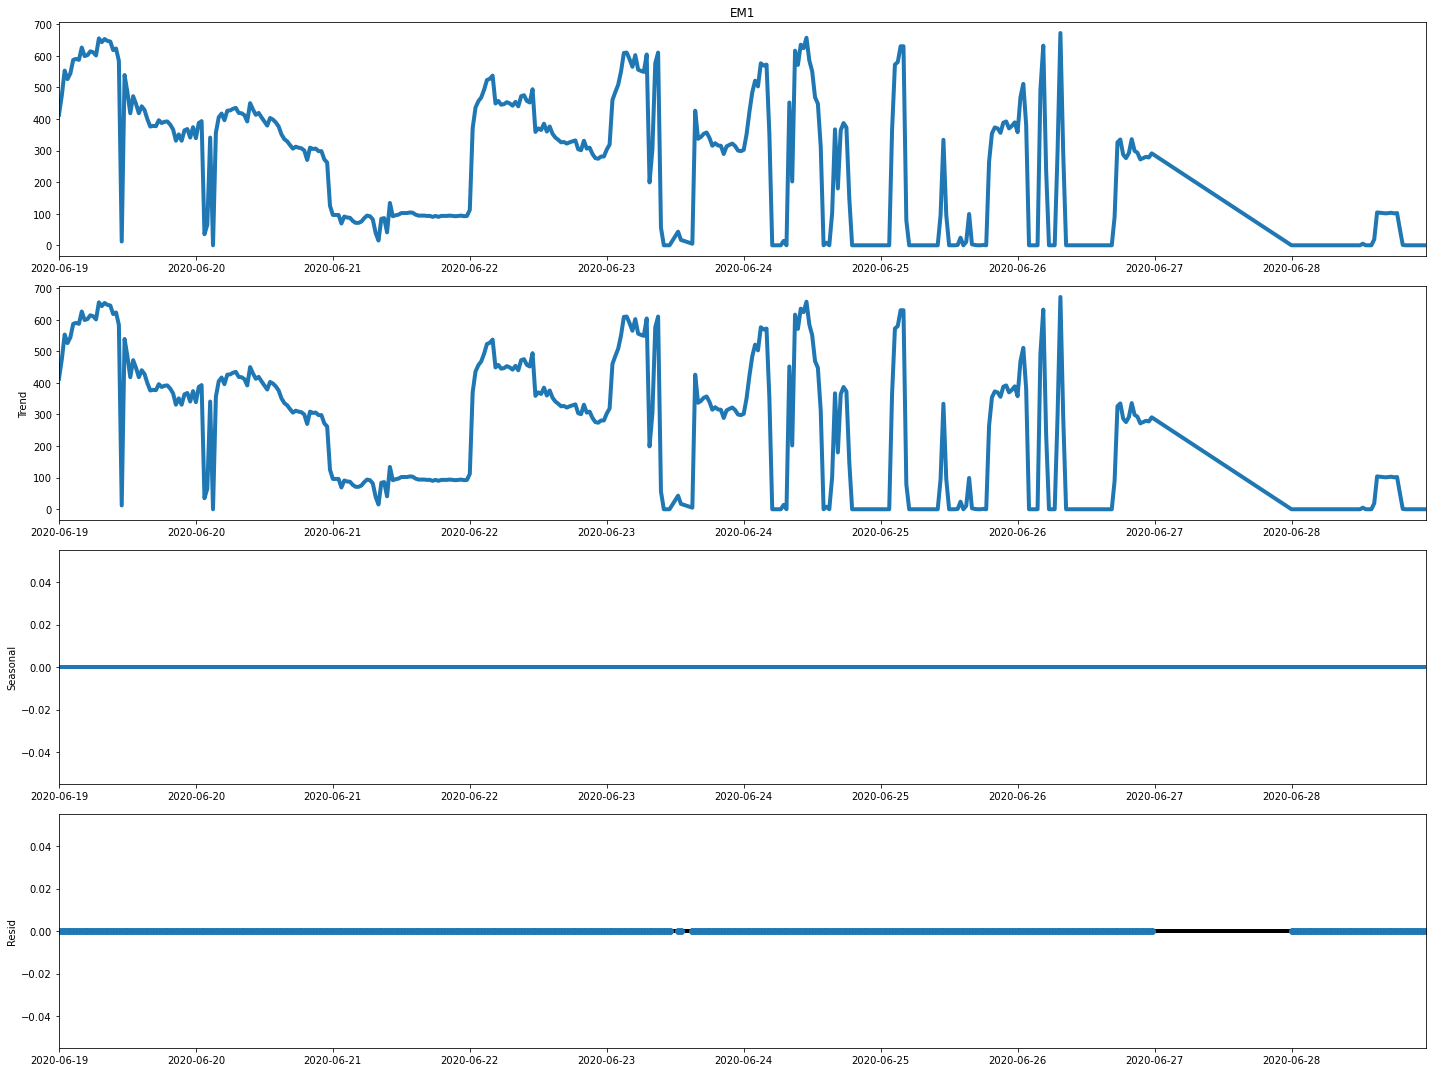

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from pylab import rcParams
result_ets = seasonal_decompose(df['EM1'], model='additive', freq=1)
rcParams['figure.figsize'] = 20,15
rcParams['lines.linewidth'] = 4 
result_ets.plot(); 

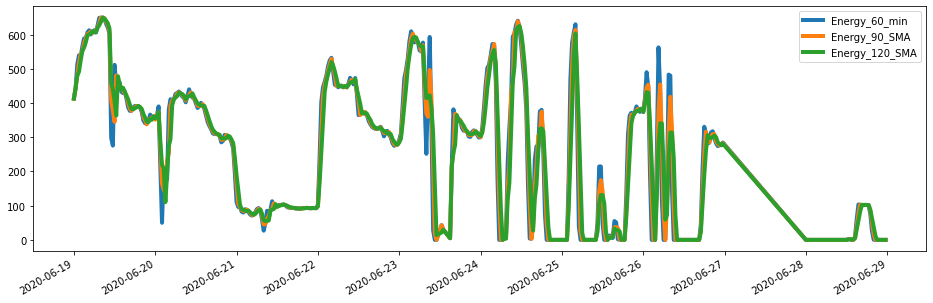

In [19]:
df['Energy_120_SMA']=df['EM1'].rolling('120T').mean()
df['Energy_90_SMA']=df['EM1'].rolling('90T').mean()
df['Energy_60_min']=df['EM1'].rolling('60T').mean()
df[['Energy_60_min','Energy_90_SMA','Energy_120_SMA']].plot(figsize = (16,5),lw=4)

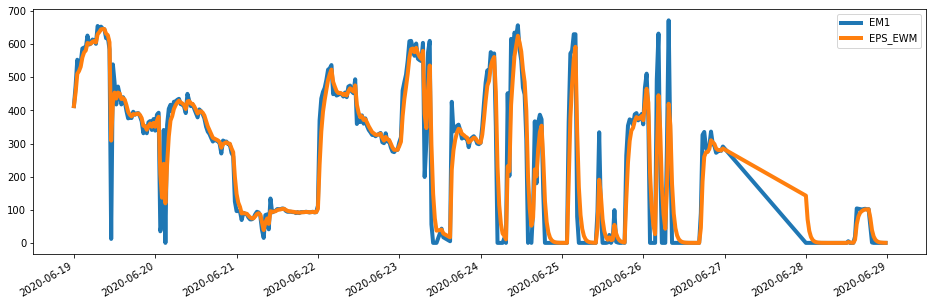

In [20]:
df['EPS_EWM']=df['EM1'].ewm(alpha=0.5).mean()
df[['EM1','EPS_EWM']].plot(figsize = (16,5),lw=4)

In [21]:
##Dickey fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['EM1'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.495209
p-value: 0.000002
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [22]:
######### log

df['log']=np.log(df['EM1']+1)
#x=df[~df['log_em1'].isin([np.nan, np.inf, -np.inf]).any(1)]


##Dickey fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['log'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.537482
p-value: 0.106619
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


In [23]:
######## Difference
df['DIFF']=df['EM1'].diff().fillna(0)
df['DIFF']
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['DIFF'])
print('ADF Statistic: %f' % result[0])
print('p-value: %.20f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.963282
p-value: 0.00000000000000811534
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.570


Text(0.5, 1.0, 'difference')

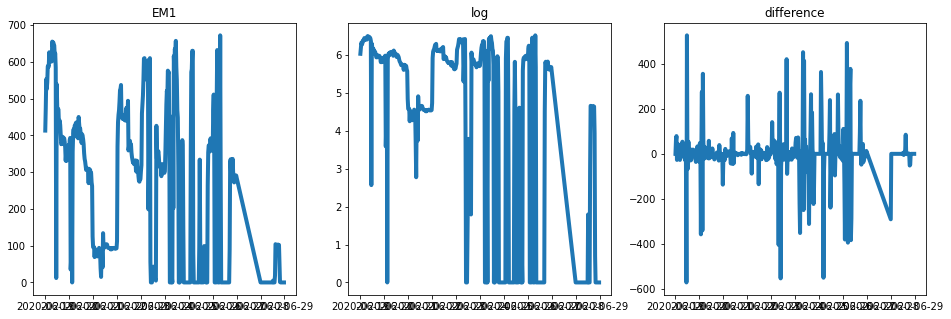

In [24]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize = (16,5))
ax1.plot(df[['EM1']])
ax1.set_title('EM1')
ax2.plot(df[['log']])
ax2.set_title('log')
ax3.plot(df[['DIFF']])
ax3.set_title('difference')

In [25]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def plotMovingAverage(series, window, plot_intervals=False, scale=1.645 , plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(16,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",lw=1)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond",lw=1)
        plt.plot(lower_bond, "r--",lw=1)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10,lw=1)
        
    plt.plot(series[window:], label="Actual values",lw=1)
    plt.legend(loc="upper left")
    plt.grid(True)

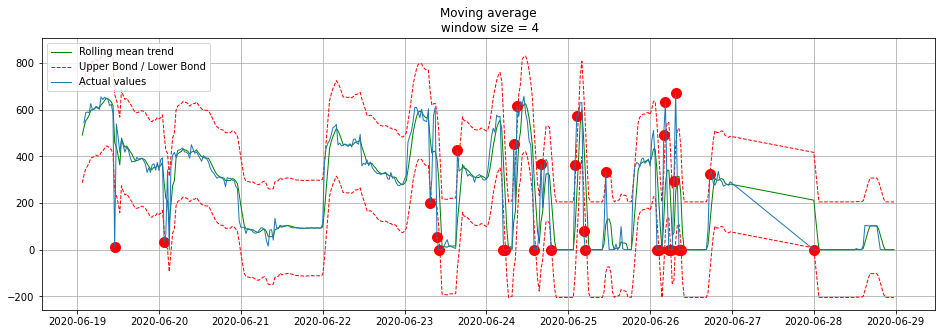

In [27]:
plotMovingAverage(df[['EM1']].dropna(), 4, plot_intervals=True, plot_anomalies=True) 

In [28]:
#df.loc[df[(np.abs(stats.zscore(df['EM1'])) > 1)].index,'EM1']=np.nan

In [29]:
#df['EM1']

In [30]:
from scipy import stats
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
data_x = df.copy()

energy_anomaly = pd.DataFrame(data_x['EM1'])
rolling_mean = energy_anomaly.rolling(window=4).mean()
mae = mean_absolute_error(energy_anomaly[4:], rolling_mean[4:])
deviation = np.std(energy_anomaly[4:] - rolling_mean[4:])
lower_bond = rolling_mean - (mae + 1.645  * deviation)
upper_bond = rolling_mean + (mae + 1.645  * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [32]:
data_x.loc[anomalies.index,'EM1'] = np.nan

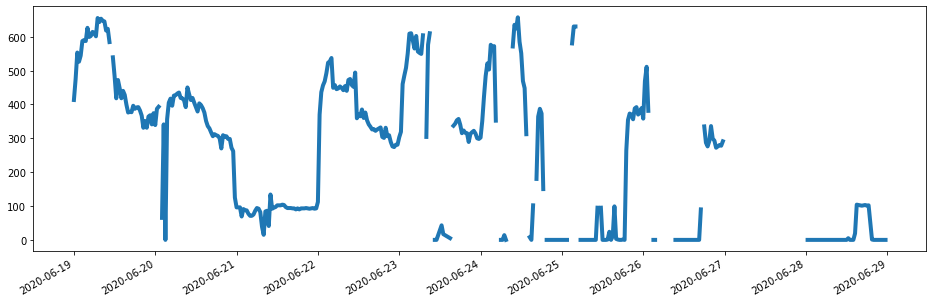

In [33]:
data_x['EM1'].plot(figsize = (16,5),lw=4)

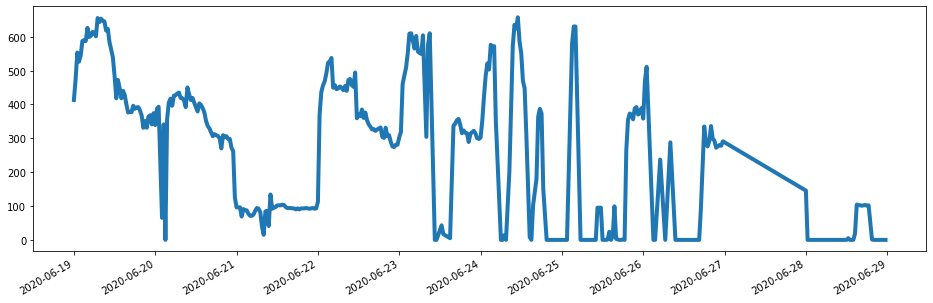

In [34]:
data_x['EM1'].interpolate(method='linear').plot(figsize = (16,5),lw=4)

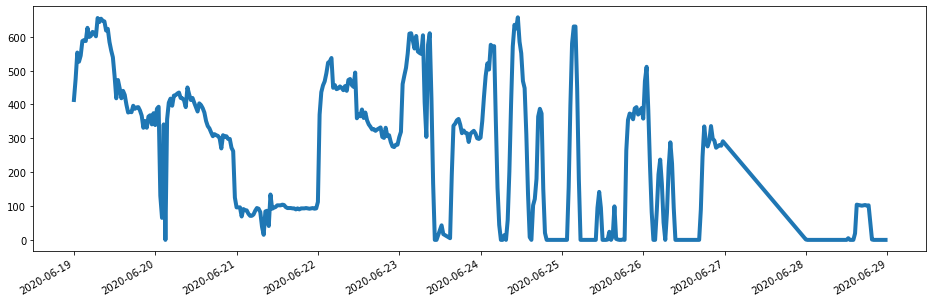

In [35]:
data_x['EM1'].interpolate(method='cubic').plot(figsize = (16,5),lw=4)

In [36]:

linear=data_x['EM1'].interpolate(method='linear')
##Dickey fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(linear.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.992524
p-value: 0.000023
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [37]:

linear1=np.log(linear+1)
from statsmodels.tsa.stattools import adfuller
result = adfuller(linear1.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.172185
p-value: 0.000010
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [38]:

cubic=data_x['EM1'].interpolate(method='cubic')
from statsmodels.tsa.stattools import adfuller
result = adfuller(cubic.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.735717
p-value: 0.000072
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [39]:

cubic1=np.log(cubic+1)
from statsmodels.tsa.stattools import adfuller
result = adfuller(cubic1.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.027899
p-value: 0.000020
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [40]:
data_x['EM1'].index

DatetimeIndex(['2020-06-19 00:00:00', '2020-06-19 00:30:00',
               '2020-06-19 01:00:00', '2020-06-19 01:30:00',
               '2020-06-19 02:00:00', '2020-06-19 02:30:00',
               '2020-06-19 03:00:00', '2020-06-19 03:30:00',
               '2020-06-19 04:00:00', '2020-06-19 04:30:00',
               ...
               '2020-06-28 19:00:00', '2020-06-28 19:30:00',
               '2020-06-28 20:00:00', '2020-06-28 20:30:00',
               '2020-06-28 21:00:00', '2020-06-28 21:30:00',
               '2020-06-28 22:00:00', '2020-06-28 22:30:00',
               '2020-06-28 23:00:00', '2020-06-28 23:30:00'],
              dtype='datetime64[ns]', name='', length=427, freq=None)

In [41]:
from scipy import interpolate
gg=interpolate.interp1d(data_x['EM1'].index, data_x['EM1'].values, kind='linear')

In [42]:
gg

In [43]:
data_x['interpolation1']=data_x['EM1'].interpolate(method='linear')

In [44]:
energy_anomaly = pd.DataFrame(data_x['interpolation1'])
rolling_mean = energy_anomaly.rolling(window=3).mean()
mae = mean_absolute_error(energy_anomaly[3:], rolling_mean[3:])
deviation = np.std(energy_anomaly[3:] - rolling_mean[3:])
lower_bond = rolling_mean - (mae + 1.96 * deviation)
upper_bond = rolling_mean + (mae + 1.96 * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [45]:
data_x.loc[anomalies.index,'interpolation1'] = np.nan

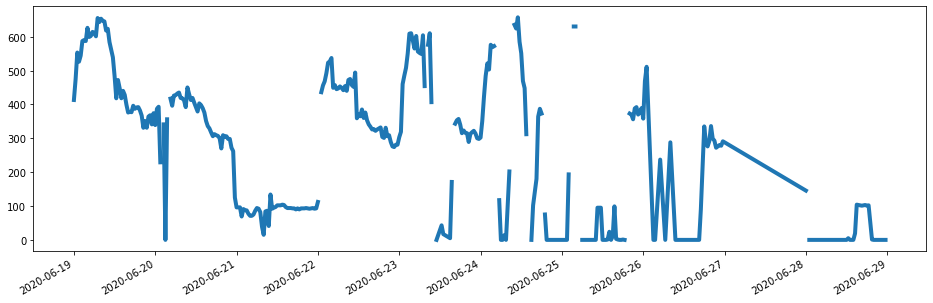

In [46]:
data_x['interpolation1'].plot(figsize = (16,5),lw=4)

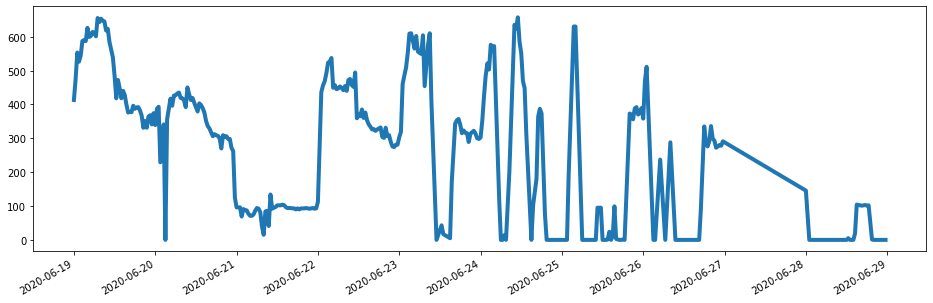

In [47]:
data_x['interpolation1'].interpolate(method='linear').plot(figsize = (16,5),lw=4)

In [48]:
data_x['interpolation1']=data_x['interpolation1'].interpolate(method='linear')

In [49]:
energy_anomaly = pd.DataFrame(data_x['interpolation1'])
rolling_mean = energy_anomaly.rolling(window=3).mean()
mae = mean_absolute_error(energy_anomaly[3:], rolling_mean[3:])
deviation = np.std(energy_anomaly[3:] - rolling_mean[3:])
lower_bond = rolling_mean - (mae + 1.96 * deviation)
upper_bond = rolling_mean + (mae + 1.96 * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [50]:
data_x.loc[anomalies.index,'interpolation1'] = np.nan

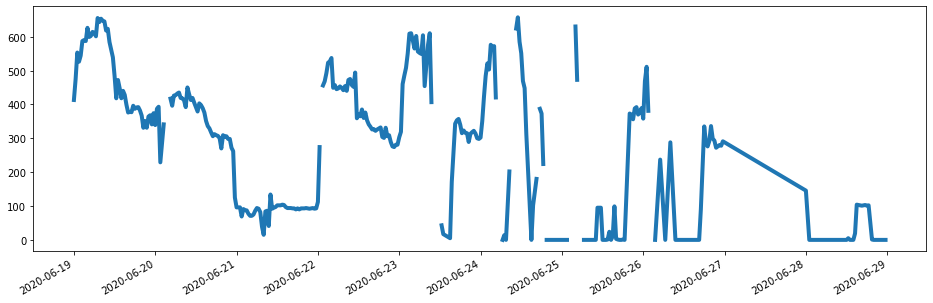

In [51]:
data_x['interpolation1'].plot(figsize = (16,5),lw=4)

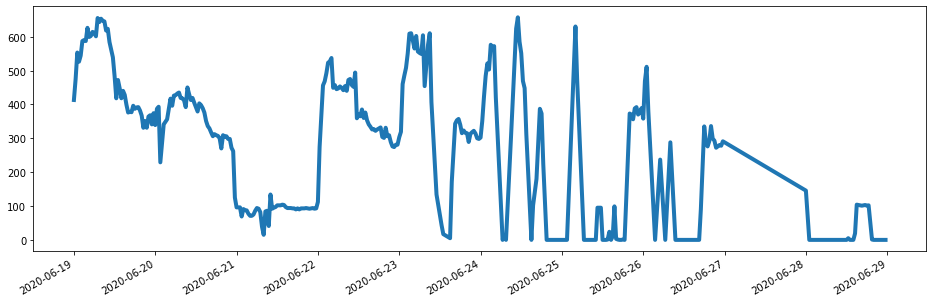

In [52]:
data_x['interpolation1'].interpolate(method='linear').plot(figsize = (16,5),lw=4)

In [53]:
##Dickey fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_x['EM1'].fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.742231
p-value: 0.000070
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [54]:

linear=data_x['EM1'].interpolate(method='linear')
linear=np.log(linear+1)
from statsmodels.tsa.stattools import adfuller
result = adfuller(linear.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.172185
p-value: 0.000010
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(df['log_em1'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())